Описание соревнования

Предскажите, как много звездочек наберет статья, зная только ее текст и время публикации

Необходимо предсказать популярность поста на Хабре по содержанию и времени публикации. Как известно, пользователи Хабра могут добавлять статьи к себе в избранное. Общее количество пользователей, которое это сделали отображается у статьи количеством звездочек. Будем считать, что число звездочек, поставленных статье, наиболее хорошо отражает ее популярность.

Более формально, в качестве метрики популярности статьи будем использовать долю статей за последний месяц, у которых количество звездочек меньше чем у текущей статьи. А точнее, доле числа звездочек можно поставить в соответствие квантили стандартного распределения, таким образом получаем числовую характеристику популярности статьи. Популярность статьи 0 означает, что статья получила ровно столько звездочек, сколько в среднем получают статьи. И соответственно чем больше звездочек получила статья по сравнению со средним, тем выше это число.

Приступим: импортируем необходимые библиотеки и скачаем данные
https://drive.google.com/file/d/1nV2qV9otN3LnVSDqy95hvpJdb6aWtATk/view?usp=sharing

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

In [2]:
train_df = pd.read_csv('howpop_train.csv')
test_df = pd.read_csv('howpop_test.csv')

train_df.head(1).T

,0
url,https://habrahabr.ru/post/18284/
domain,habrahabr.ru
post_id,18284
published,2008-01-01 18:19:00
author,@Tapac
flow,develop
polling,False
content_len,4305
title,Новогодний подарок блоггерам — WordPress 2.3.2
comments,0


In [3]:
train_df.shape, test_df.shape

((134137, 17), (3990, 9))

Убедимся, что данные отсортированы по признаку published

<AxesSubplot:>

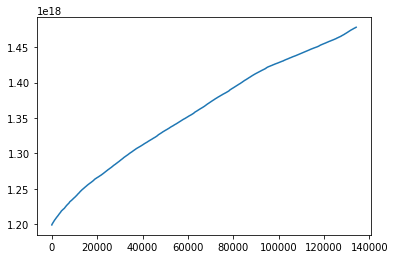

In [4]:
train_df['published'].apply(lambda ts: pd.to_datetime(ts).value).plot()

 Есть ли в train_df признаки, корреляция между которыми больше 0.9? Обратите внимание, именно различные признаки - корреляция признака с самим собой естественно больше 0.9 :)

In [5]:
corr = train_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,post_id,polling,content_len,comments,favs,views,votes_plus,votes_minus,views_lognorm,favs_lognorm,comments_lognorm
post_id,1.000000,0.081628,0.241384,-0.147763,0.089313,0.132385,-0.187885,-0.235594,-0.010376,-0.005845,-0.001605
polling,0.081628,1.000000,-0.003337,0.042605,0.006882,0.025660,-0.033505,0.027116,-0.003523,-0.036385,0.071417
content_len,0.241384,-0.003337,1.000000,-0.023544,0.308194,0.204101,0.068779,-0.078686,0.246063,0.356481,0.073132
comments,-0.147763,0.042605,-0.023544,1.000000,0.164166,0.290035,0.613961,0.457638,0.349568,0.278942,0.662740
favs,0.089313,0.006882,0.308194,0.164166,1.000000,0.634304,0.416241,0.062877,0.456097,0.587982,0.263239
views,0.132385,0.025660,0.204101,0.290035,0.634304,1.000000,0.396849,0.128654,0.585105,0.406782,0.326427
votes_plus,-0.187885,-0.033505,0.068779,0.613961,0.416241,0.396849,1.000000,0.464168,0.414232,0.449712,0.525081
votes_minus,-0.235594,0.027116,-0.078686,0.457638,0.062877,0.128654,0.464168,1.000000,0.146609,0.088226,0.355458
views_lognorm,-0.010376,-0.003523,0.246063,0.349568,0.456097,0.585105,0.414232,0.146609,1.000000,0.688811,0.546530
favs_lognorm,-0.005845,-0.036385,0.356481,0.278942,0.587982,0.406782,0.449712,0.088226,0.688811,1.000000,0.479476


В каком году было больше всего публикаций? (Рассматриваем train_df)

In [6]:
train_df['published'] = pd.to_datetime(train_df['published'])
train_df['year'] = [i.year for i in train_df['published']]

In [7]:
year_number = train_df.loc[:, 'year'].value_counts()

<BarContainer object of 9 artists>

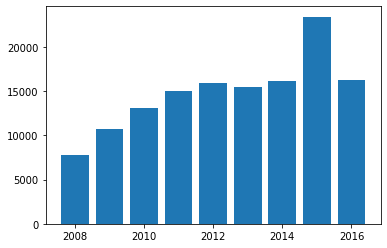

In [8]:
plt.bar(x=year_number.index, height=year_number)

## Разбиение на train/valid
Используем только признаки 'author', 'flow', 'domain' и 'title'

In [9]:
features = ['author', 'flow', 'domain','title']
train_size = int(0.7 * train_df.shape[0])

In [10]:
len(train_df), train_size

(134137, 93895)

In [11]:
X, y = train_df.loc[:, features],  train_df['favs_lognorm']

In [12]:
X_test = test_df.loc[:, features]

In [13]:
X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:,:]

y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]

## Применение TfidfVectorizer
TF-IDF (от англ. TF — term frequency, IDF — inverse document frequency) — статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. Вес некоторого слова пропорционален количеству употребления этого слова в документе, и обратно пропорционален частоте употребления слова в других документах коллекции. Подробнее в источнике

TfidfVectorizer преобразует тексты в матрицу TF-IDF признаков.

Основные параметры TfidfVectorizer в sklearn:

min_df - при построении словаря слова, которые встречаются реже, чем указанное значение, игнорируются

max_df - при построении словаря слова, которые встречаются чаще, чем указанное значение, игнорируются

analyzer - определяет, строятся ли признаки по словам или по символам (буквам)

ngram_range - определяет, формируются ли признаки только из отдельных слов или из нескольких слов (в случае с analyzer='char' задает количество символов). Например, если указать analyzer='word' и ngram_range=(1,3),то признаки будут формироваться из отдельных слов, из пар слов и из троек слов.

stop_words - слова, которые игнорируются при построении матрицы

Более подробно с параметрами можно ознакомиться в документации

Инициализируйте TfidfVectorizer с параметрами min_df=3, max_df=0.3 и ngram_range=(1, 3).
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']

In [14]:
tfid_vect = TfidfVectorizer(min_df=3, max_df=0.3, ngram_range=(1, 3))

In [15]:
X_train_title = tfid_vect.fit_transform(X_train['title'])
X_valid_title  =tfid_vect.transform(X_valid['title'])
X_test_title  =tfid_vect.transform(X_test['title'])

Какой размер у полученного словаря?

In [16]:
len(tfid_vect.vocabulary_)

50624

Какой индекс у слова 'python'?

In [17]:
tfid_vect.vocabulary_['python']

9065

Инициализируйте TfidfVectorizer, указав analyzer='char'.

Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']

In [18]:
tfid_char = TfidfVectorizer(analyzer='char')

In [40]:
X_train_title_ch = tfid_char.fit_transform(X_train['title'])
X_valid_title_ch = tfid_char.transform(X_valid['title'])
X_test_title_ch = tfid_char.transform(X_test['title'])

Какой размер у полученного словаря?

In [20]:
len(tfid_char.vocabulary_)

218

In [21]:
print(tfid_char.vocabulary_)

{'н': 133, 'о': 134, 'в': 122, 'г': 123, 'д': 124, 'и': 128, 'й': 129, ' ': 0, 'п': 135, 'а': 120, 'р': 136, 'к': 130, 'б': 121, 'л': 131, 'е': 125, 'м': 132, '—': 170, 'w': 61, 'o': 53, 'r': 56, 'd': 42, 'p': 54, 'e': 43, 's': 57, '2': 18, '.': 14, '3': 19, 'с': 137, 'у': 139, 'ш': 144, 'я': 151, 'ц': 142, ',': 12, 'т': 138, 'ж': 126, 'ф': 140, 'ь': 148, 'ч': 143, 'i': 47, 'h': 46, 'n': 52, 'm': 51, 'b': 40, 'l': 50, '0': 16, 'щ': 145, 'k': 49, 'v': 60, 'a': 39, 'u': 59, ':': 26, 'c': 41, 'з': 127, 'ы': 147, '«': 76, '»': 85, 'х': 141, 'j': 48, '?': 31, 't': 58, '-': 13, '1': 17, '8': 24, '!': 1, '9': 25, '5': 21, '7': 23, 'q': 55, 'y': 63, 'x': 62, 'g': 45, 'ю': 150, 'ъ': 146, '4': 20, '=': 29, '(': 8, ')': 9, '+': 11, 'f': 44, '…': 178, 'э': 149, '6': 22, 'z': 64, '/': 15, '$': 4, 'ё': 152, "'": 7, '№': 187, '–': 169, '[': 33, ']': 35, '_': 37, '\xa0': 71, '*': 10, '%': 5, '{': 65, '}': 67, '’': 173, '|': 66, '“': 174, '”': 175, ';': 27, '&': 6, '‐': 167, '>': 30, '@': 32, '\\': 34,

## Работа с категориальными признаками

Для обработки категориальных признаков 'author', 'flow', 'domain' мы будем использовать DictVectorizer из sklearn.

In [22]:
feats = ['author', 'flow', 'domain']
X_train[feats][:5]

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,NaN,geektimes.ru


Рассмотрим как он работает на примере первых пяти строк

Заполним пропуски

In [23]:
X_train[feats][:5].fillna('-')

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,-,geektimes.ru


Преобразуем датафрейм в словарь, где ключами являются индексы объектов (именно для этого мы транспонировали датафрейм), а значениями являются словари в виде 'название_колонки':'значение'

In [24]:
X_train[feats][:5].fillna('-').T.to_dict()

{0: {'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'},
 1: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 2: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 3: {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'},
 4: {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}}

В DictVectorizer нам нужно будет передать список словарей для каждого объекта в виде 'название_колонки':'значение', поэтому используем .values()

In [25]:
X_train[feats][:5].fillna('-').T.to_dict().values()

dict_values([{'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}])

В итоге получается разреженная матрица

In [26]:
dict_vect = DictVectorizer()
dict_vect_matrix = dict_vect.fit_transform(X_train[feats][:5].fillna('-').T.to_dict().values())
dict_vect_matrix

<5x9 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

Но можно преобразовать ее в numpy array с помощью .toarray()

In [27]:
dict_vect_matrix.toarray()

array([[0., 0., 1., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 1., 0., 1., 0., 0.]])

В получившейся матрице 5 строк (по числу объектов) и 9 столбцов

Далее разберемся почему колонок именно 9

In [28]:
dict_vect_matrix.shape

(5, 9)

Посмотрим сколько уникальных значений в каждой колонке.
Суммарно их 9 - столько же, сколько и колонок. Это объясняется тем, что для категориальных признаков со строковыми значениями DictVectorizer делает кодирование бинарными признаками - каждому уникальному значению признака соответствует один новый бинарный признак, который равен 1 только в том случае, если в исходной матрице этот признак принимает значение, которому соответствует эта колонка новой матрицы.

In [29]:
for col in feats:
    print(col,len(X_train[col][:5].fillna('-').unique()))

author 4
flow 3
domain 2


Также можно посмотреть что означает каждая колонка полученной матрицы

например, самая первая колонка называется 'author=@DezmASter' - то есть принимает значение 1 только если автор @DezmASter

In [30]:
dict_vect.feature_names_

['author=@DezmASter',
 'author=@Taoorus',
 'author=@Tapac',
 'author=@dennydo',
 'domain=geektimes.ru',
 'domain=habrahabr.ru',
 'flow=-',
 'flow=design',
 'flow=develop']

Инициализируйте DictVectorizer с параметрами по умолчанию.
Примените метод fit_transform к X_train[feats] и метод transform к X_valid[feats] и X_test[feats]

In [36]:
vectorizer_feats = DictVectorizer()

X_train_feats = vectorizer_feats.fit_transform(X_train[feats][:].fillna('-').T.to_dict().values())
X_valid_feats = vectorizer_feats.transform(X_valid[feats][:].fillna('-').T.to_dict().values())
X_test_feats = vectorizer_feats.transform(X_test[feats][:].fillna('-').T.to_dict().values())

In [37]:
X_train_feats.shape

(93895, 17869)

Соединим все полученные матрицы при помощи scipy.sparse.hstack()

In [41]:
import scipy
X_train_new = scipy.sparse.hstack([X_train_title, X_train_feats, X_train_title_ch])
X_valid_new = scipy.sparse.hstack([X_valid_title, X_valid_feats, X_valid_title_ch])
X_test_new =  scipy.sparse.hstack([X_test_title, X_test_feats, X_test_title_ch])

## Обучение модели

Далее будем использовать Ridge, линейную модель с l2-регуляризацией.

Основной параметр Ridge - alpha, коэффициент регуляризации. Регуляризация используется для улучшения обобщающей способности модели - прибавляя к функционалу потерь сумму квадратов весов, умноженную на коэффициент регуляризации (та самая alpha), мы штрафуем модель за слишком большие значения весов и не позволяем ей переобучаться. Чем больше этот коээфициент, тем сильнее эффект.

Обучите две модели на X_train_new, y_train, задав в первой alpha=0.1 и random_state = 1, а во второй alpha=1.0 и random_state = 1

Рассчитайте среднеквадратичную ошибку каждой модели (mean_squared_error). Сравните значения ошибки на обучающей и тестовой выборках и ответьте на вопросы.

In [44]:
%%time
model1 = Ridge(alpha=0.1, random_state=1)
model1.fit(X_train_new, y_train)

Wall time: 3.98 s


Ridge(alpha=0.1, random_state=1)

In [45]:
prediction1 = model1.predict(X_valid_new)
mean_squared_error(y_valid, prediction1)

0.9031661010515443

In [46]:
%%time
model2 = Ridge(alpha=1, random_state=1)
model2.fit(X_train_new, y_train)

Wall time: 1.96 s


Ridge(alpha=1, random_state=1)

In [47]:
prediction2 = model2.predict(X_valid_new)
mean_squared_error(y_valid, prediction2)

0.700997767013925